# Connectome pipeline
This tutorial shows how to use the NIAK connectome pipeline to generate seed-based functional connectivity maps on a single subject from the COBRE "lightweight" sample. 
  * **More documentation**: on the various pipeline options can be found on the [here](http://niak.simexp-lab.org/pipe_connectome.html). 
  * **.m script**: The notebook and associated Matlab script are available [here](https://nbviewer.jupyter.org/github/SIMEXP/niak_tutorials/blob/master/niak_tutorial_rmap_connectome.ipynb).
  * **Time for completion**: this tutorial will take 5-10 minutes to complete. 

## Preparing files

### Functional MRI 
First download a small preprocessed fMRI dataset. 

In [1]:
clear
path_data = [pwd filesep];
[status,msg,data_fmri] = niak_wget('cobre_lightweight20_nii');

--2017-04-06 02:34:53--  https://www.nitrc.org/frs/download.php/9401/cobre_lightweight20.zip
Resolving www.nitrc.org (www.nitrc.org)... 132.239.16.23
Connecting to www.nitrc.org (www.nitrc.org)|132.239.16.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89902898 (86M) [application/force-download]
Saving to: `/sandbox/home/git/niak_tutorials/cobre_lightweight20/cobre_lightweight20.zip'

100%[======================================>] 89,902,898  1.46M/s   in 52s     

2017-04-06 02:35:45 (1.66 MB/s) - `/sandbox/home/git/niak_tutorials/cobre_lightweight20/cobre_lightweight20.zip' saved [89902898/89902898]

Deleting file '/sandbox/home/git/niak_tutorials/cobre_lightweight20/cobre_lightweight20.zip' 
ans = 0


When starting from fMRI data preprocessed with NIAK, it is possible to use `niak_grab_fmri_preprocess` on the output folder to collect the file names, as described in the [pipeline documentation](http://niak.simexp-lab.org/pipe_connectome.html). In this case, we explicitely list all the files

In [2]:
file_pheno = [data_fmri.path filesep 'phenotypic_data.tsv.gz'];
tab = niak_read_csv_cell(file_pheno);
list_subject = tab(2:end,1);
files_in = struct;
for ss = 1:length(list_subject)
    files_in.fmri.(list_subject{ss}).sess1.rest = [data_fmri.path filesep 'fmri_' list_subject{ss} '.nii.gz'];
end

### Brain parcellation
The second input of the pipeline is a set of brain parcels. We will just download the so-called Cambridge functional template. 



In [3]:
[status,msg,data_template] = niak_wget('cambridge_template_mnc1');

--2017-04-06 02:35:48--  http://files.figshare.com/1861821/template_cambridge_basc_multiscale_mnc_sym.zip
Resolving files.figshare.com (files.figshare.com)... 52.211.238.180, 54.194.135.36
Connecting to files.figshare.com (files.figshare.com)|52.211.238.180|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ndownloader.figshare.com/files/1861821 [following]
--2017-04-06 02:35:48--  https://ndownloader.figshare.com/files/1861821
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.49.0.95, 34.251.222.116, 54.246.157.89, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.49.0.95|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/1861821/template_cambridge_basc_multiscale_mnc_sym.zip [following]
--2017-04-06 02:35:49--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/1861821/template_cambridge_basc_multiscale_mnc_sym.zip


We are going to pick the parcellation into 7 distributed networks.

In [4]:
files_in.network = [data_template.path filesep 'template_cambridge_basc_multiscale_sym_scale007.mnc.gz'];

### List of seeds

The next step is to generate a list of seeds. This requires creating a text file that looks like:
```
        , index
 MOTOR  , 3
 DMN    , 5
```
We are going to use NIAK's tool to write comma-separated values (CSV) in a file:

In [5]:
files_in.seeds = [path_data 'list_seeds.csv'];
opt_csv.labels_x = { 'MOTOR' , 'DMN' }; % The labels for the network
opt_csv.labels_y = { 'index' };
tab = [3 ; 5];
niak_write_csv(files_in.seeds,tab,opt_csv);

# Set the options of the pipeline
Now we set up where to store the results:

In [6]:
opt.folder_out = [path_data 'connectome'];

We set options such that we will not generate graph properties, just the correlation maps:

In [7]:
opt.flag_p2p = false; % No parcel-to-parcel correlation values
opt.flag_global_prop = false; % No global graph properties
opt.flag_local_prop  = false; % No local graph properties
opt.flag_rmap = true; % Generate correlation maps

# Run the pipeline
Now let's run the pipeline:

In [8]:
opt.flag_test = false; 
[pipeline,opt] = niak_pipeline_connectome(files_in,opt); 

Adding seed MOTOR (parcel number 3)
Adding seed DMN (parcel number 5)

Logs will be stored in /sandbox/home/git/niak_tutorials/connectome/logs/
Generating dependencies ...
   Percentage completed :  0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100- 0.05 sec
Setting up the to-do list ...
   I found 43 job(s) to do.
I could not find any log file. This pipeline has not been started (yet?). Press CTRL-C to cancel.
Deamon started on 06-Apr-2017 02:35:53
06-Apr-2017 02:35:53 Starting the pipeline manager...
06-Apr-2017 02:35:53 Starting the garbage collector...
06-Apr-2017 02:35:53 Starting worker number 1...
06-Apr-2017 02:35:53 Starting worker number 2...
06-Apr-2017 02:35:53 Starting worker number 3...
06-Apr-2017 02:35:53 Starting worker number 4...

Pipeline started on 06-Apr-2017 02:35:54
user: , host: 404bac75ac66, system: unix
****************************************
06-Apr-2017 02:35:56 mask_rois          submitted  (1 run | 0 fail | 0 done | 42 left)
06-Apr-2017 02:35:

# Reviewing outputs

All the correlation maps have been generated in the subfolder called `rmap_seeds`, inside the output folder. There are first two average (across all subjects) maps, for each selected seed. We can have a quick look at them. Note that the files have been named using the identification codes in the file `files_in.seeds`.  

In [9]:
file_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'average_rmap_DMN.nii.gz'];
file_motor = [opt.folder_out filesep 'rmap_seeds' filesep 'average_rmap_MOTOR.nii.gz'];
[hdr,rmap_dmn]   = niak_read_vol(file_dmn);
[hdr,rmap_motor] = niak_read_vol(file_motor);
size(rmap_dmn)
size(rmap_motor)

ans =

   27   32   26

ans =

   27   32   26



We will now use `niak_vol2img` to generate a series of axial slices for both maps. 

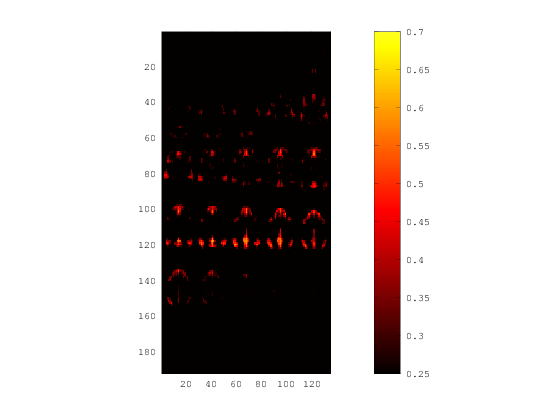

In [10]:
% The default-mode network
opt_v = struct;
opt_v.vol_limits = [0.25 0.7];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_dmn,opt_v)

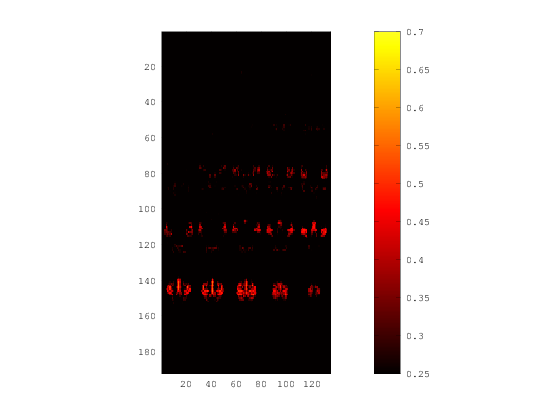

In [11]:
% The sensorimotor network
opt_v = struct;
opt_v.vol_limits = [0.25 0.7];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_motor,opt_v)

There are also two files which contain the seeds as binary masks. E.g.:

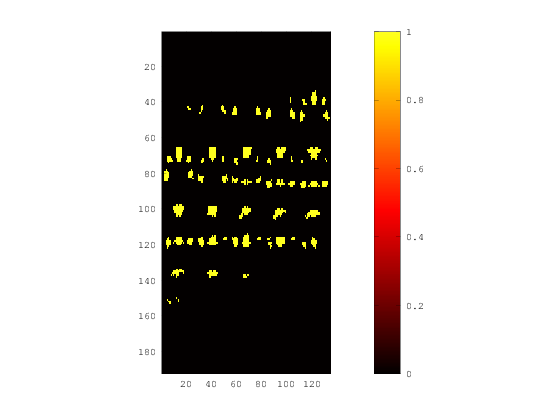

In [12]:
file_mask_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'mask_DMN.nii.gz'];
[hdr,mask_dmn]   = niak_read_vol(file_mask_dmn);
opt_v = struct;
opt_v.vol_limits = [0 1];
opt_v.type_color = 'hot_cold';
niak_montage(mask_dmn,opt_v)

Finally, there are also individual connectivity maps for each subject, named using the IDs we used in `files_in.fmri`. If multiple runs were specified per subject, the pipeline would average the maps from all runs.  

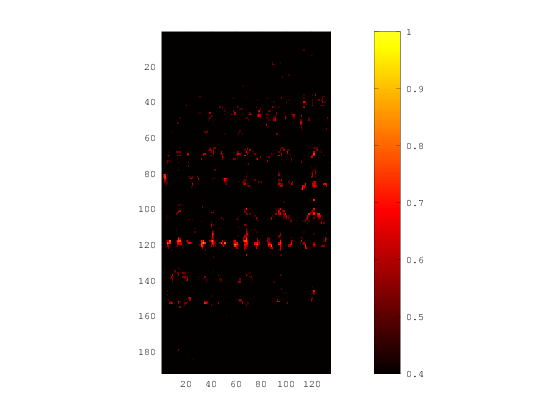

In [13]:
file_dmn_40003   = [opt.folder_out filesep 'rmap_seeds' filesep 'rmap_40003_DMN.nii.gz'];
[hdr,rmap_dmn_40003]   = niak_read_vol(file_dmn_40003);
opt_v = struct;
opt_v.vol_limits = [0.4 1];
opt_v.type_color = 'hot_cold';
niak_montage(rmap_dmn_40003,opt_v)